In [73]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .master('local[*]')\
        .getOrCreate()
sc = spark.sparkContext

In [75]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
#change the directory
%cd /content/drive/My Drive/Colab Notebooks/big-data-Colab/
#pwd
!ls

/content/drive/My Drive/Colab Notebooks/big-data-Colab
'10.Spark-Classification.ipynb .ipynb'	 JosephNikhilReddy_MT_Q1_B.txt
 11.ipynb				 JosephNikhilReddy_MT_Q2_A.txt
 11.Spark-Classifier-evaluation.ipynb	 JosephNikhilReddy_MT_Q2_B.txt
 12.Spark-Clustering.ipynb		 JosephNikhilReddy_MT_Q3_A.txt
 2.DataCopy.ipynb			 JosephNikhilReddy_MT_Q3_B.txt
 2.WordCount.ipynb			 make_join2data.py
 4.MR-DataJoin.ipynb			'Midterm Section2 Q1.ipynb'
 4.MR-WordCount.ipynb			'Midterm Section2 Q2.ipynb'
 5.MR-DataJoin2.ipynb			'Midterm Section2 Q3.ipynb'
 6.MR-WordCountReducer.ipynb		 minute_weather.csv.gz
 7.Spark-WordCount.ipynb		 MT_Q1_make_data.py
 8.Spark-SQL.ipynb			 MT_Q2_make_data.py
 8.Spark-Streaming.ipynb		 MT_Q3_make_data.py
 9.Spark-Handling-missing-values.ipynb	 out
 ad-clicks.csv.gz			 out0
 BigData.ipynb				 out2
 buy-clicks.csv.gz			 out3
 daily_weather.csv			 outDataJoin
 game-clicks.csv.gz			 outDataJoin2
 hadoop-3.3.4				 predictions.csv
 hadoop-3.3.4.tar.gz			 Q1out
 join1_FileA.txt

In [77]:
!cp utils.py /content/utils.py

In [78]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import utils
%matplotlib inline

In [79]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('/content/drive/My Drive/Colab Notebooks/big-data-Colab/minute_weather.csv.gz',
                          format='com.databricks.spark.csv',
                          header = 'true',
                          inferSchema='true')

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [80]:
df.count()

1587257

In [81]:
filteredDF = df.filter((df.rowID % 10) == 0)
filteredDF.count()


158726

In [82]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
air_pressure,158726,916.830161410269,3.0517165528304218,905.0,929.5
air_temp,158726,61.8515891536367,11.83356921064173,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905971,0.0,359.0
avg_wind_speed,158680,2.7752148979077846,2.0576239697426213,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838614,0.0,359.0
max_wind_speed,158680,3.400557726241582,2.4188016208098935,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784639,0.0,359.0
min_wind_speed,158680,2.1346641038568777,1.742112505242431,0.0,31.6


In [83]:
filteredDF.filter(filteredDF.rain_accumulation ==0.0).count()

157812

In [84]:
filteredDF.filter(filteredDF.rain_duration == 0.0).count()

157237

In [85]:
workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

In [86]:
before = workingDF.count()
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

46

In [87]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [88]:
featuresUsed = ['air_pressure','air_temp','avg_wind_direction','avg_wind_speed','max_wind_direction','max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [89]:
scaler = StandardScaler(inputCol= "features_unscaled", outputCol="features",withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)


In [90]:
scaledData = scaledData.select("features","rowID")

elbowset= scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

In [91]:
clusters = range(2,31)
wsseList = utils.elbow(elbowset, clusters)


Training for cluster size 2 
......................WSSE = 114993.73508526216 
Training for cluster size 3 
......................WSSE = 102466.31220353257 
Training for cluster size 4 
......................WSSE = 95151.50105820014 
Training for cluster size 5 
......................WSSE = 92076.32347113916 
Training for cluster size 6 
......................WSSE = 84759.76929146728 
Training for cluster size 7 
......................WSSE = 82689.08581108255 
Training for cluster size 8 
......................WSSE = 78897.42030240592 
Training for cluster size 9 
......................WSSE = 76048.71871742973 
Training for cluster size 10 
......................WSSE = 74359.22850986672 
Training for cluster size 11 
......................WSSE = 71334.69986795336 
Training for cluster size 12 
......................WSSE = 70102.20833343921 
Training for cluster size 13 
......................WSSE = 68751.17112036466 
Training for cluster size 14 
......................WSSE = 67481.78146

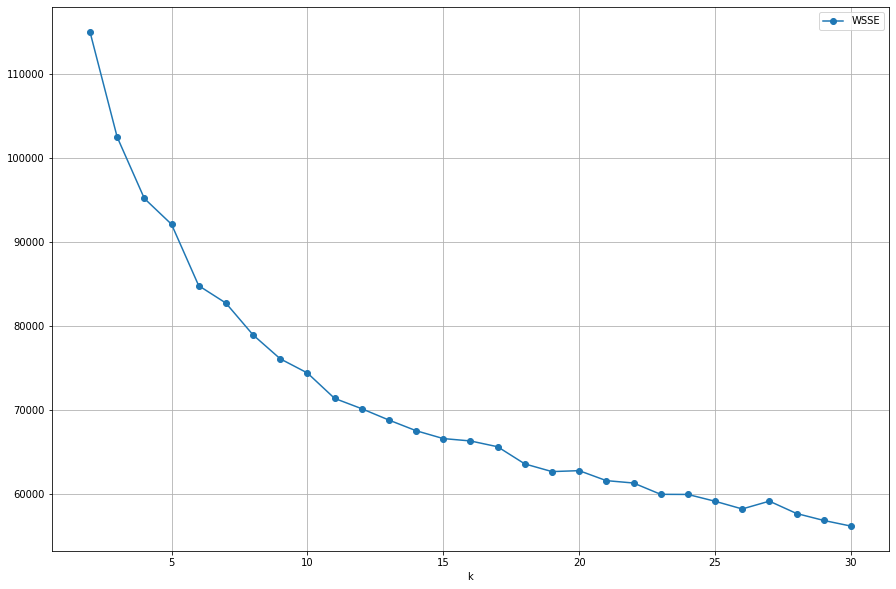

In [92]:
utils.elbow_plot(wsseList, clusters)

In [93]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

In [94]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [95]:
centers = model.clusterCenters()
centers

[array([-0.24087536,  0.89317498, -1.30906851, -0.57520841, -1.16974144,
        -0.59159648, -0.60687036]),
 array([ 0.30093585,  0.78641609,  1.31154052, -0.63097076,  1.57376747,
        -0.58240516, -0.75424234]),
 array([ 1.02863670e-03, -7.85281288e-01, -1.18366452e+00, -5.69017339e-01,
        -1.03073232e+00, -5.83853886e-01,  9.19797457e-01]),
 array([-0.87741375, -1.14844494,  0.37170793,  0.2393311 ,  0.47266284,
         0.22842591,  1.3456467 ]),
 array([ 1.2063516 , -0.34616575, -1.15622055,  2.67963877, -1.05958875,
         2.80546069, -1.14594124]),
 array([ 0.34667066, -0.96360578,  0.66675181, -0.54003592,  0.86118186,
        -0.52192382,  1.08559485]),
 array([-0.16974415,  0.61495037,  0.41023033,  0.6670633 ,  0.51934772,
         0.60869618, -0.18038098]),
 array([ 0.23478366,  0.32138349,  1.88791989, -0.65209959, -1.5511956 ,
        -0.5768484 , -0.28495592]),
 array([ 1.31481435, -0.07639869, -1.10903028, -0.47613978, -0.94738474,
        -0.47485927, -0.904

In [96]:
P = utils.pd_centers(featuresUsed, centers)

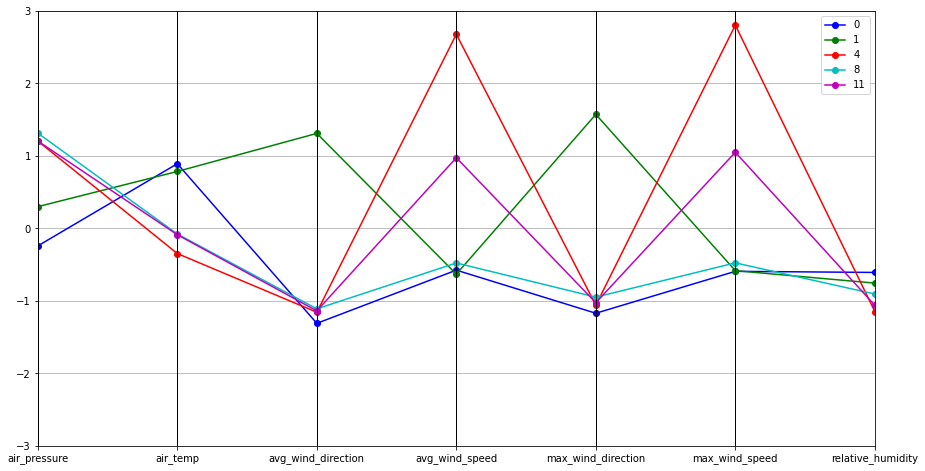

In [97]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

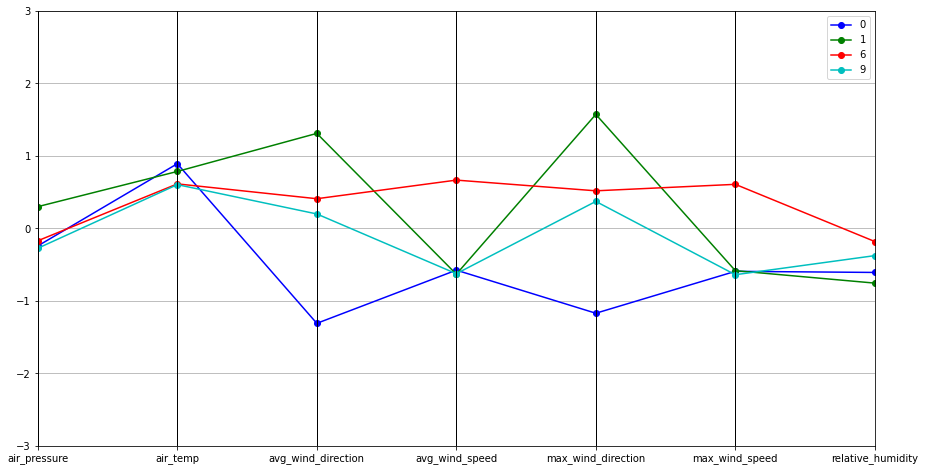

In [98]:
utils.parallel_plot(P[P['air_temp'] > 0.5], P)

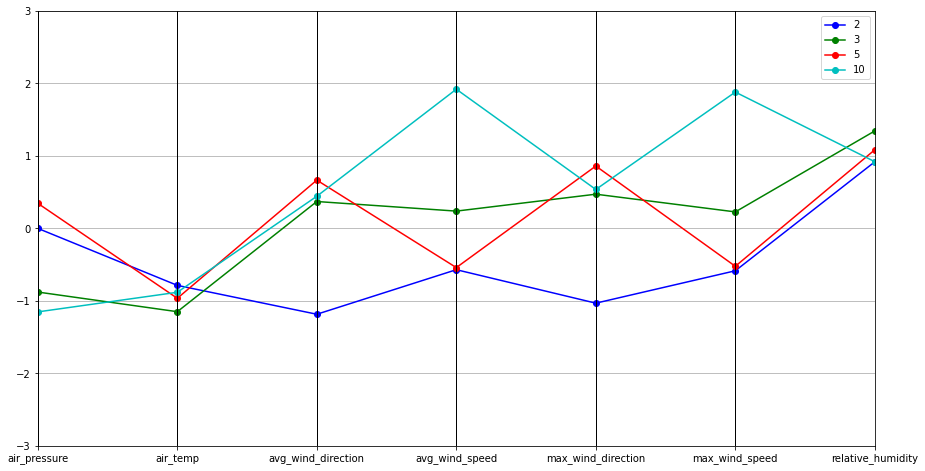

In [99]:
utils.parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)], P)

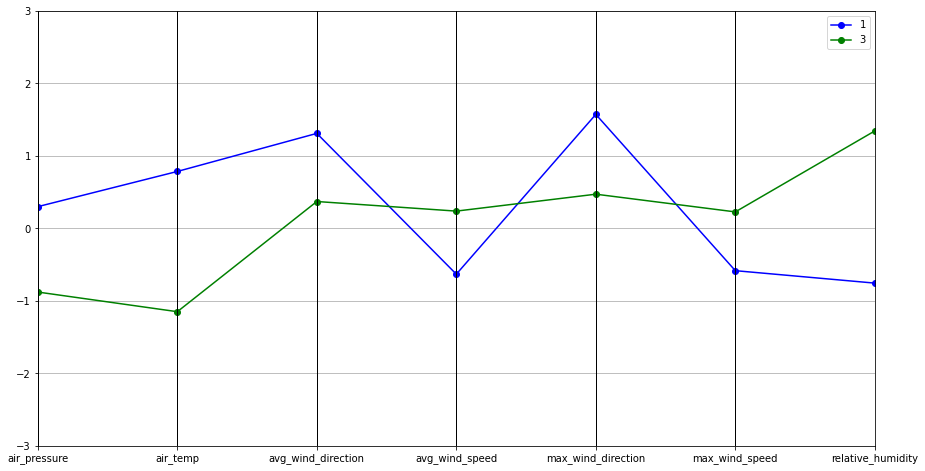

In [100]:
utils.parallel_plot(P.iloc[[1,3]], P)